### CNN for pixel-wise ship detection on Sentinel 1 IW GRDH image

The image is resized from 10m to 40m resolution images considering the S1 GRD image resolution over the open ocean.  
The analysis are carried with bot CNN model and CA-CFAR algorithm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# change directory where requirments.txt is located
%cd  /content/drive/My Drive/projects/sar_ship_detect/scripts
!ls

/content/drive/My Drive/projects/sar_ship_detect/scripts
cfar.py       images	       __pycache__  requirements.txt   utils.py
cnn_utils.py  model_notebooks  README.md    under_development


In [ ]:
# set up the required librariesS
!pip install -r requirements.txt

In [3]:
#NOTE: The TF/Keras libraries are throwing a conflict and causing for the  
#      terminal to die if they are loaded after calling openCV library
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation, Reshape
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

Using TensorFlow backend.


In [4]:
import os
import time

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterio as rio
import glob
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, bbox_draw, data_extractor, dB2natural
from cfar import CA_CFAR
from cnn_utils import SAR_ObjectDetect_CNN

In [5]:
# PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
PATH = '/content/drive/My Drive/projects/sar_ship_detect'
# Configs
RADAR_PATH = join(PATH, 'data/SAR_test/test1019')
OUT_PATH = RADAR_PATH

In [6]:
radar_VV = glob.glob(join(RADAR_PATH, '*VV*'))[0]
angle_im = glob.glob(join(RADAR_PATH, '*angle*'))[0]

src_VV = rio.open(radar_VV)
src_angle = rio.open(angle_im)
Window = (80, 80)

# get the dimencions for cropping the image
height, width = (src_VV.shape[0]//Window[0])*Window[0], (src_VV.shape[1]//Window[1])*Window[1]

print(pd.Series(src_VV.meta),'\n',pd.Series(src_angle.meta))

VV_natural = src_VV.read(1)[:height, :width]
# VV_natural = dB2natural(VV_dB)
angle = src_angle.read(1)[:height, :width]

driver                                                   GTiff
dtype                                                  float32
nodata                                                    None
width                                                    29475
height                                                   12377
count                                                        1
crs                                                     (init)
transform    (8.983152841195215e-05, 0.0, 3.820984061002384...
dtype: object 
 driver                                                   GTiff
dtype                                                  float32
nodata                                                    None
width                                                    29475
height                                                   12377
count                                                        1
crs                                                     (init)
transform    (8.983152841195215e-05, 0.

### Buiding the Model

In [7]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    #model.add(Flatten())
    # fully connected block 1
    #model.add(Dense(64))
    
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    # reshape the tensor vector indo NxN for passing into Conv2D
    #model.add(Reshape((20,20), input_shape=(12,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    model.add(Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'))  
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    #mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    mypotim = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', #'sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
#weights_path = ".model_weights_Deschesne_pixel_wise.hdf5"
weights_path = join(PATH, 'model_weights', '.Deschesne_pixel_wise_res_80.hdf5')
callbacks = get_callbacks(filepath=weights_path, patience=4) # increased the "patience"

In [9]:
# load the model
gmodel = load_model(weights_path)

#in case of using iterative function per image chip
SAR_ObjectDetect_CNN(nrcs=VV_natural, inc_angle=angle, cnn_model=gmodel, window=Window)

In [10]:
# resize and crop the image to fit exactly with window size
VV_natural = im_resize(VV_natural, (7360, 3080), interpolation=cv2.INTER_NEAREST)[:3040, :7360]
angle = im_resize(angle, (7360, 3080), interpolation=cv2.INTER_NEAREST)[:3040, :7360]

### Object detection with CNN

In [13]:
window = (80,80)
y, x = window
out_VV = []
out_angle = []

for i in range(0, VV_natural.shape[0], y):
    j_num = []
    for j in range(0, VV_natural.shape[1], x):
        # get the window to apply the complete chain of analysis
        sub_image_VV = VV_natural[i:i+y, j:j+x]
        sub_image_angle = angle[i:i+y, j:j+x]
        out_VV.append(sub_image_VV)
        out_angle.append(sub_image_angle)
        
array_vv = np.array(out_VV)
array_angle = np.array(out_angle)
test_data = np.concatenate([array_vv[:, :, :, np.newaxis], array_angle[:, :, :, np.newaxis]], axis=-1)

In [14]:
y_pred_class = gmodel.predict_classes(test_data, batch_size=64, verbose=1) # batch_size=64, verbose=1

3496/3496 [==============================] - 783s 224ms/step


In [15]:
y_pred_class = y_pred_class.squeeze()

width = y_pred_class.shape[0]//(VV_natural.shape[0]//y)

sar_classified = np.vstack([np.hstack(y_pred_class[i:i+width]) for i in range(0, y_pred_class.shape[0], width)])

In [20]:
# randomly choose an object for ploting
pred_objects = np.argwhere(sar_classified==1)
rand_ind = np.random.choice(pred_objects.shape[0], size=1, replace=False)
ind = pred_objects[rand_ind]
ind

array([[2429, 5389]])

In [77]:
pred_objects

array([], shape=(0, 2), dtype=int64)

In [17]:
def chip_extractor(image, index, size=20):
    return image[index[0]-size:index[0]+size, index[1]-size:index[1]+size]

### Object detection with CA-CFAR

In [18]:
# Define parameters for CFAR
params = [10, 10, 1, 1]
P_fa = 10e-4

detedt_cfar = CA_CFAR(VV_natural, params, P_fa)

Text(0.5, 1.0, 'CFAR prediction')

<Figure size 432x288 with 0 Axes>

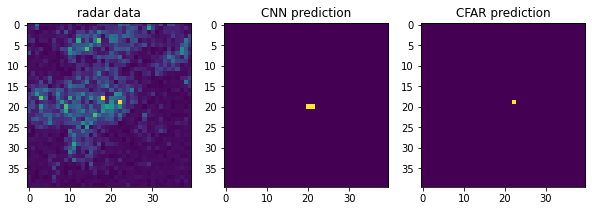

In [19]:
# visualize images
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(chip_extractor(VV_natural, ind[0]))
axarr[0].set_title('radar data')
axarr[1].imshow(chip_extractor(sar_classified, ind[0]))  
axarr[1].set_title('CNN prediction')
axarr[2].imshow(chip_extractor(detedt_cfar,ind[0]))  
axarr[2].set_title('CFAR prediction')

Text(0.5, 1.0, 'CFAR prediction')

<Figure size 432x288 with 0 Axes>

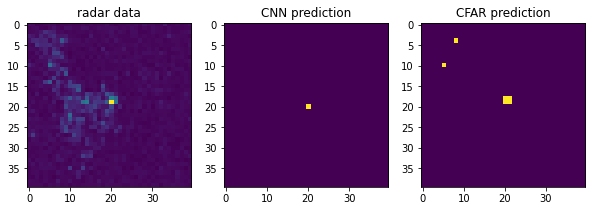

In [21]:
# visualize images
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(chip_extractor(VV_natural, ind[0]))
axarr[0].set_title('radar data')
axarr[1].imshow(chip_extractor(sar_classified, ind[0]))  
axarr[1].set_title('CNN prediction')
axarr[2].imshow(chip_extractor(detedt_cfar, ind[0]))  
axarr[2].set_title('CFAR prediction')